# Boost Optimization Simulation
## Determine which boost level to apply (if any) across in-network suppliers in order optimize expected ATA and cost given out of network (OON) likelihood and average cost

### Configuration

##### Package Imports

In [1]:
import collections
import datetime
import itertools
import matplotlib.pyplot as plt
import mcdm
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
import warnings

##### Session Settings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [10, 5]

##### Simulation Configuration - OON Cost, ATA

In [3]:
config_oon_cost = 250
config_oon_ata = 0.05
config_bau_ranking = ['Supplier 5', 'Supplier 2', 'Supplier 1', 'Supplier 3', 'Supplier 4']
config_cost_weight = 0.7
config_ata_weight = 0.3

### Define Functions & Classes

##### Miscellaneous

In [4]:
def create_bimodal_distribution(mu1, mu2, std1, std2, n):
    """
    Create bimodal distribution given means (mu), standard
    deviations (std), and number of observations (n)
    Returns:
        list
    """
    n1 = int(n / 2)
    n2 = n - n1
    dist1 = np.random.normal(mu1, std1, n1)
    dist2 = np.random.normal(mu2, std2, n2)
    return list(np.concatenate([dist1, dist2]))


def normalize_to_median(iterable):
    """
    Normalize using (Xi - MEDIAN(X)) / STDEV(X) rather than the conventional mean
    Args:
        iterable: some iterable object with floats
    Returns:
        (normalized) iterable
    """
    median_x = np.median(iterable)
    stdev_x = np.std(iterable)
    return [(x - median_x) / stdev_x for x in iterable]


def min_max_normalize(iterable):
    """
    Normalize using (Xi - MEDIAN(X)) / STDEV(X) rather than the conventional mean
    Args:
        iterable: some iterable object with floats
    Returns:
        (normalized) iterable
    """
    return [(x - min(iterable)) / (max(iterable) - min(iterable)) for x in iterable]


def print_timestamp_message(message, timestamp_format = '%Y-%m-%d %H:%M:%S'):
    """
    Print formatted timestamp followed by custom message
    Args:
        message (str): string to concatenate with timestamp
        timestamp_format (str): format for datetime string. defaults to '%Y-%m-%d %H:%M:%S'
    """
    ts_string = datetime.datetime.fromtimestamp(time.time()).strftime(timestamp_format)
    print(f'{ts_string}: {message}')

##### Supplier Data Simulation

In [5]:
class SimulatedSuppliers:
    def __init__(self,
                 n_suppliers,
                 accept_plot_attribs = {'x_label' : 'Boost Dollars',
                                        'y_label' : 'Acceptance Probability',
                                        'marker' : 'o'},
                 base_cost_range = [80, 130],
                 boost_values = list(range(0,50,5)),
                 mean_acceptance1 = 0.05,
                 stdev_acceptance1 = 0.07,
                 mean_acceptance2 = 0.25,
                 stdev_acceptance2 = 0.25,
                 random_seed = 832021):
        """
        Simulate supplier data with cost, ata service level probability, and acceptance probabilities
        given specified ranges
        
        Example:
            supplier_simulation = SimulatedSuppliers(supplier_names = [f'Supplier {n}' for n in range(1,4)])
            supplier_simulation_df = supplier_simulation.generate_supplier_info() 
        """
        self.n_suppliers = n_suppliers
        self.accept_plot_attribs = accept_plot_attribs
        self.base_cost_range = base_cost_range
        self.boost_values = boost_values
        self.mean_acceptance1 = mean_acceptance1
        self.stdev_acceptance1 = stdev_acceptance1
        self.mean_acceptance2 = mean_acceptance2
        self.stdev_acceptance2 = stdev_acceptance2
        self.random_seed = random_seed
        
        
    def get_random_boost_probs(self):
        """
        Generate random acceptance probabilities given a range of boost values
        that follow a 2nd order polynomial pattern
        Args:
            boost_values (list): list of dollar values used in boost
            mean_acceptance1 (float): average acceptance rate at $0 boost for part of bimodal distribution
            stdev_acceptance1 (float): standard deviation of acceptance rate at $0 boost for part of bimodal distribution
            mean_acceptance2 (float): average acceptance rate at $0 boost for part of bimodal distribution
            stdev_acceptance2 (float): standard deviation of acceptance rate at $0 boost for part of bimodal distribution
            supplier_name (str): name of simulated supplier
        Returns:
            pandas.DataFrame object with fields 'boost_dollars', 'accept_prob', and 'supplier'
        """
        np.random.seed(self.random_seed)
        random.seed(self.random_seed)
        supplier_names = [f'Supplier {n}' for n in range(1, (self.n_suppliers + 1))]
        boost_df_list = []
        for sn in supplier_names:
            #acceptance_distr = np.random.normal(self.mean_acceptance, self.stdev_acceptance, 1000)
            acceptance_distr = create_bimodal_distribution(self.mean_acceptance1, self.mean_acceptance2,
                                                           self.stdev_acceptance1, self.stdev_acceptance2, 1000)
            
            b0 = random.choice([x for x in acceptance_distr if (x > 0) and (x < 1)])
            max_b1 = ((1 - b0) / max(self.boost_values))
            b1 = random.choice(np.linspace(0, max_b1, 100))
            max_b2 = (1 - (b0 + (b1 * max(self.boost_values)))) / max(self.boost_values)**2
            b2 = random.choice(np.linspace(0, max_b2, 100))
            probs = []
            for x in self.boost_values:
                p = b0 + (b1 * x) + (b2 * x**2)
                probs.append(p)
            boost_df = pd.DataFrame({'boost_dollars' : self.boost_values, 'accept_prob' : probs})
            boost_df['supplier'] = sn
            boost_df_list.append(boost_df)
        output_df = pd.concat(boost_df_list, axis = 0)
        return output_df
    
    
    def generate_supplier_info(self):
        """
        Generate a pandas.DataFrame object with costs in a given range and ata probabilities
        0 to 1 representing the likelihood of completing service in under 45 minutes
        Args:
            supplier_names (list): list of supplier names
            base_cost_range (list): minimum and maximum baseline cost for each supplier
        Returns:
            pandas.DataFrame object with fields 'supplier', 'base_cost', 'ata_prob' which
            is merged with the output of get_random_boost_probs()
        """
        random.seed(self.random_seed)
        supplier_names = [f'Supplier {n}' for n in range(1, (self.n_suppliers + 1))]
        boost_prob_df = self.get_random_boost_probs()
        ata_probs = [random.choice(np.linspace(0,1,100)) for i in range(len(supplier_names))]
        base_cost = [random.choice(np.linspace(self.base_cost_range[0], self.base_cost_range[1], 100)) for i in range(len(supplier_names))]
        supplier_info_df = pd.DataFrame({'supplier' : supplier_names, 'base_cost' : base_cost, 'ata_prob' : ata_probs})
        supplier_boost_info_df = pd.merge(supplier_info_df, boost_prob_df, on = 'supplier', how = 'left')
        supplier_boost_info_df['total_cost'] = supplier_boost_info_df['base_cost'] + supplier_boost_info_df['boost_dollars']
        supplier_boost_info_df['ata_per_dollar'] = supplier_boost_info_df['ata_prob'] / supplier_boost_info_df['total_cost']
        return supplier_boost_info_df
        
    
    def plot_supplier_acceptance(self):
        """
        Plot curves of acceptance probability for each supplier based on boost dollars
        offered using the output of the generate_supplier_info() attribute
        Args:
            accept_plot_attribs (dict): dictionary with plot attributes defined
            by keys 'x_label', 'y_label', and 'marker'
        Returns:
            None
        """
        sup_df = self.generate_supplier_info()
        sns.lineplot(x = 'boost_dollars',
                     y = 'accept_prob',
                     hue = 'supplier',
                     marker = self.accept_plot_attribs.get('marker'),  data = sup_df)
        plt.ylabel(self.accept_plot_attribs.get('y_label'))
        plt.xlabel(self.accept_plot_attribs.get('x_label'))
        plt.show()

##### Optimization

In [6]:
class BoostOptimizer:
    """
    Given a rank-ordered list of suppliers (and their cost, acceptance probabilities,
    ata probabilities) calculate the expected cost and ata of providing sequential offers
    for every level of possible boost (applied to all suppliers)
    Args:
        dframe (pandas.DataFrame): input DataFrame object
        total_cost_col (string): column name representing total cost of each supplier
        ata_prob_col (string): column name representing the probability of ATA falling below service level
        accept_prob_col (string):  column name with floats representing acceptance likelihood of each supplier
        boost_col (string): column name with floats representing boost dollars applied
        oon_cost (float): float representing average out of network (OON) cost
        oon_ata (float): float representing average ATA probability for out of network (OON)
        cost_weight (float): weight to use in MCDM ranking for expected cost. defaults to 0.5.
        ata_weight (float): weight to use in MCDM ranking for expected ata. defaults to 0.5.
        sort_order (list): list with customized sorting to be applied to <sort_col>. defaults to None.
        sort_col (string): column name with values to be sorted according to <sort_order>. defaults to None.
    """
    def __init__(self, dframe, total_cost_col, ata_prob_col, accept_prob_col, boost_col, oon_cost, oon_ata,
                 cost_weight = 0.5, ata_weight = 0.5, sort_order = None, sort_col = None):
        self.dframe = dframe
        self.total_cost_col = total_cost_col
        self.ata_prob_col = ata_prob_col
        self.accept_prob_col = accept_prob_col
        self.boost_col = boost_col
        self.oon_cost = oon_cost
        self.oon_ata = oon_ata
        self.cost_weight = cost_weight
        self.ata_weight = ata_weight
        self.sort_order = sort_order
        self.sort_col = sort_col
        
        
    def calc_exp_network_result(self, df):
        """
        Given a rank-ordered list of suppliers (and their cost, acceptance probabilities,
        ata probabilities) calculate the expected cost and ata of 
        providing sequential offers for a *single* boost level
        Args:
            dframe (pandas.DataFrame): input DataFrame object
            total_cost (string): column name representing total cost of each supplier
            ata_prob (string): column name representing the probability of ATA falling below service level
            accept_prob (string):  column name with floats representing acceptance likelihood of each supplier
            sort_order (list): list with customized sorting to be applied to <sort_col>. defaults to None.
            sort_col (string): column name with values to be sorted according to <sort_order>. defaults to None.
        Returns:
            dframe_copy (pandas.DataFrame): pandas.DataFrame with additional columns 'selection_prob', 'expected_cost', 'expected_ata_prob'
            agg_exp_cost (float): float representing expected cost from providing sequential offers
            agg_exp_ata_prob (float): float representing expected ata probability from providing sequential offers
            oon_prob (float): probability of offer going out of network (inverse of cumulative acceptance probability)
        """
        # Copy dataframe and apply custom sorting
        dframe_copy = df.copy()
        if self.sort_order is not None:
            sort_dict = dict(zip(self.sort_order, range(len(self.sort_order))))
            dframe_copy['sort_value'] = dframe_copy[self.sort_col].map(sort_dict)
            dframe_copy = dframe_copy.sort_values('sort_value')
            dframe_copy.drop('sort_value', axis = 1, inplace = True)
        
        # Probabilities of each supplier being accepted given sequential order and acceptance probabilities
        selection_prob = []
        for i, ap in enumerate(dframe_copy[self.accept_prob_col]):
            if i == 0:
                selection_prob.append(ap)
            else:
                selection_prob.append((1 - sum(selection_prob)) * ap)
        
        # Expected cost, ata probability, out of network probability
        agg_exp_cost = np.dot(selection_prob, dframe_copy[self.total_cost_col])
        agg_exp_ata_prob = np.dot(selection_prob, dframe_copy[self.ata_prob_col])
        dframe_copy['selection_prob'] = selection_prob
        dframe_copy['expected_cost'] = dframe_copy['selection_prob'] * dframe_copy[self.total_cost_col]
        dframe_copy['expected_ata_prob'] = dframe_copy['selection_prob'] * dframe_copy[self.ata_prob_col]
        oon_prob = 1 - sum(selection_prob)
        
        return dframe_copy, agg_exp_cost, agg_exp_ata_prob, oon_prob
        
    
    def calc_boost_results(self):
        """
        Calculate expected cost and ATA for each boost level from
        probability-weighted combinations of out of network (OON) and in-network outcomes
        """
        # Aggregate outcomes for each boost $ level
        unique_boost_amounts = sorted(list(set(self.dframe[self.boost_col])))
        boost_df_list = []
        exp_cost_list = []
        ata_prob_list = []
        oon_prob_list = []
        
        for uba in unique_boost_amounts:
            boost_level_df = self.dframe[self.dframe[self.boost_col] == uba]
            boost_dframe, boost_agg_exp_cost, boost_agg_exp_ata_prob, boost_oon_prob = self.calc_exp_network_result(df = boost_level_df)
            boost_df_list.append(boost_dframe)
            exp_cost_list.append(boost_agg_exp_cost)
            ata_prob_list.append(boost_agg_exp_ata_prob)
            oon_prob_list.append(boost_oon_prob)
            
        output_df = pd.DataFrame({self.boost_col : unique_boost_amounts,
                                  'network_cost' : exp_cost_list,
                                  'network_ata' : ata_prob_list,
                                  'network_prob' : [1 - x for x in oon_prob_list],
                                  'oon_cost' : self.oon_cost,
                                  'oon_ata' : self.oon_ata,
                                  'oon_prob' : oon_prob_list})
        
        # Calculate expected ATA and cost for each boost $ level
        expected_cost = []
        expected_ata = []
        for i in range(output_df.shape[0]):
            net_exp_cost = list(output_df['network_cost'])[i] * list(output_df['network_prob'])[i]
            oon_exp_cost = list(output_df['oon_cost'])[i] * list(output_df['oon_prob'])[i]
            expected_cost.append(net_exp_cost + oon_exp_cost)
            
            net_exp_ata = list(output_df['network_ata'])[i] * list(output_df['network_prob'])[i]
            oon_exp_ata = list(output_df['oon_ata'])[i] * list(output_df['oon_prob'])[i]
            expected_ata.append(net_exp_ata + oon_exp_ata)
        
        output_df['expected_cost'] = expected_cost
        output_df['expected_ata'] = expected_ata
        return output_df
    
    
    def mcdm_rank_boost_levels(self):
        """
        Use MCDM to determine which boost level to select based on expected cost and expected ata
        Returns:
            pandas.DataFrame : identical to output of self.calc_boost_results() with additional
            column 'mcdm_value' which has descending rank order of boost choices given the
            cost and ata weights specified in self.cost_weight, self.ata_weight
        """
        exp_boost_results = self.calc_boost_results()
        norm_exp_cost = min_max_normalize(-1 * exp_boost_results['expected_cost'])
        norm_exp_ata = min_max_normalize(exp_boost_results['expected_ata'])
        x_matrix = [[norm_exp_cost[i], norm_exp_ata[i]] for i in range(exp_boost_results.shape[0])]        
        mcdm_ranking = mcdm.rank(x_matrix, w_vector = [self.cost_weight, self.ata_weight], alt_names = list(exp_boost_results[self.boost_col]))
        mcdm_ranking.sort(key = lambda y: y[0])
        mcdm_vals = []
        for i, b in enumerate(exp_boost_results[self.boost_col]):
            mcdm_vals.append([x[1] for x in mcdm_ranking if x[0] == b][0])
        exp_boost_results['mcdm_value'] = mcdm_vals
        best_boost = list(exp_boost_results[exp_boost_results['mcdm_value'] == max(exp_boost_results['mcdm_value'])][self.boost_col])[0]
        print_timestamp_message(f'Given weights [Cost: {self.cost_weight}, ATA: {self.ata_weight}], \
                                the optimal boost amount is ${best_boost}')
        return exp_boost_results

### Execution

##### Simulate Network of Suppliers

In [7]:
supplier_simulation = SimulatedSuppliers(n_suppliers = 5, random_seed = 705)
supplier_simulation_df = supplier_simulation.generate_supplier_info()    
supplier_simulation_df.head()

,supplier,base_cost,ata_prob,boost_dollars,accept_prob,total_cost,ata_per_dollar
0,Supplier 1,100.707071,0.131313,0,0.077790,100.707071,0.001304
1,Supplier 1,100.707071,0.131313,5,0.083037,105.707071,0.001242
2,Supplier 1,100.707071,0.131313,10,0.096708,110.707071,0.001186
3,Supplier 1,100.707071,0.131313,15,0.118804,115.707071,0.001135
4,Supplier 1,100.707071,0.131313,20,0.149324,120.707071,0.001088


Note that we have acceptance probability for each supplier at every boost $ amount. This assumes we have modeled the relationship between acceptance and boost.

In [8]:
supplier_simulation_df.tail()

,supplier,base_cost,ata_prob,boost_dollars,accept_prob,total_cost,ata_per_dollar
45,Supplier 5,130.0,0.393939,25,0.445512,155.0,0.002542
46,Supplier 5,130.0,0.393939,30,0.554678,160.0,0.002462
47,Supplier 5,130.0,0.393939,35,0.673564,165.0,0.002388
48,Supplier 5,130.0,0.393939,40,0.802169,170.0,0.002317
49,Supplier 5,130.0,0.393939,45,0.940495,175.0,0.002251


##### Plot Supplier Acceptance Probability ~ Boost Dollar Amount

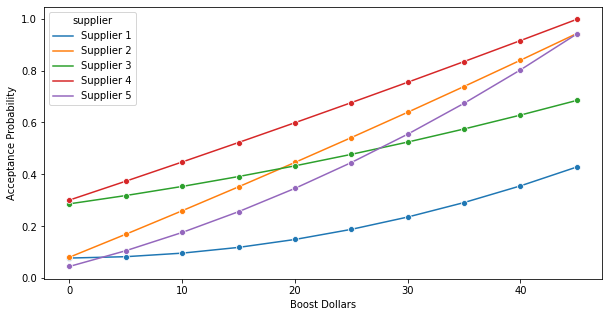

In [9]:
supplier_simulation.plot_supplier_acceptance()

##### Apply Optimization

i.e. Determine which boost amount ($0-45) applied to every in-network supplier results in the MCDM weighted expected cost, expected ATA

In [10]:
optimizer = BoostOptimizer(dframe = supplier_simulation_df,
                           total_cost_col = 'total_cost',
                           ata_prob_col = 'ata_prob',
                           accept_prob_col = 'accept_prob',
                           boost_col = 'boost_dollars',
                           oon_cost = config_oon_cost,
                           oon_ata = config_oon_ata,
                           sort_order = config_bau_ranking,
                           cost_weight = config_cost_weight,
                           ata_weight = config_ata_weight,
                           sort_col = 'supplier')

In [11]:
boost_choice = optimizer.mcdm_rank_boost_levels()

2021-08-10 10:51:50: Given weights [Cost: 0.7, ATA: 0.3],                                 the optimal boost amount is $15


In [12]:
boost_choice

,boost_dollars,network_cost,network_ata,network_prob,oon_cost,oon_ata,oon_prob,expected_cost,expected_ata,mcdm_value
0,0,68.263929,0.339790,0.596631,250,0.05,0.403369,141.570666,0.222897,0.493781
1,5,84.044252,0.361909,0.709523,250,0.05,0.290477,132.250579,0.271306,0.734678
2,10,98.814855,0.369585,0.803413,250,0.05,0.196587,128.535882,0.306759,0.861884
3,15,112.228649,0.365959,0.876721,250,0.05,0.123279,129.213017,0.327008,0.890260
4,20,124.184017,0.355515,0.929889,250,0.05,0.070111,133.005086,0.334095,0.843948
5,25,134.822731,0.343565,0.965073,250,0.05,0.034927,138.845536,0.333311,0.750035
6,30,144.495140,0.335602,0.985670,250,0.05,0.014330,146.007076,0.331509,0.633256
7,35,153.693788,0.336589,0.995737,250,0.05,0.004263,154.104346,0.335368,0.512600
8,40,162.961022,0.350228,0.999354,250,0.05,0.000646,163.017262,0.350034,0.399903
9,45,172.781664,0.378308,0.999998,250,0.05,0.000002,172.781807,0.378308,0.300000


##### Visualize Results

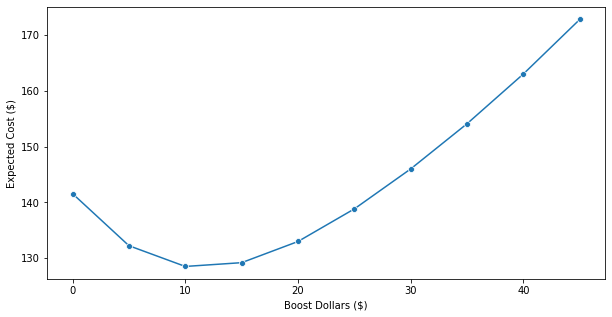

In [13]:
sns.lineplot(x = 'boost_dollars', y = 'expected_cost', marker = 'o',  data = boost_choice)
plt.ylabel('Expected Cost ($)')
plt.xlabel('Boost Dollars ($)')
plt.show()

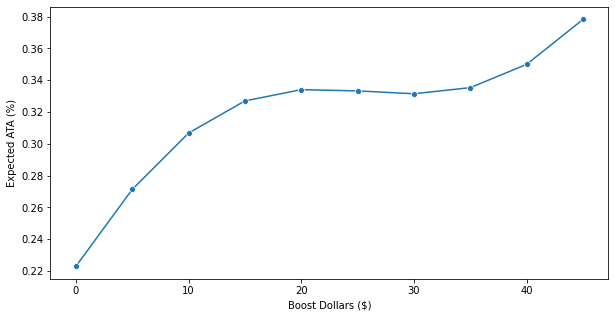

In [14]:
sns.lineplot(x = 'boost_dollars', y = 'expected_ata', marker = 'o',  data = boost_choice)
plt.ylabel('Expected ATA (%)')
plt.xlabel('Boost Dollars ($)')
plt.show()

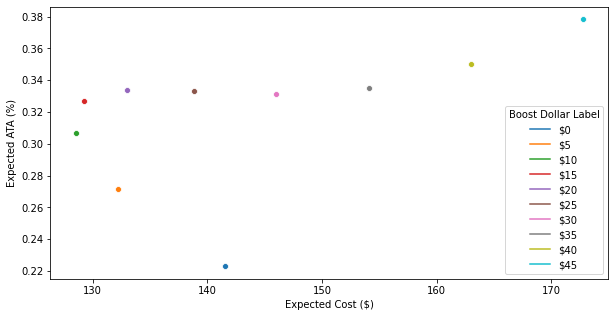

In [15]:
boost_choice['Boost Dollar Label'] = [f'${x}' for x in boost_choice['boost_dollars']]
sns.lineplot(x = 'expected_cost', y = 'expected_ata', marker = 'o', hue = 'Boost Dollar Label', data = boost_choice)
plt.ylabel('Expected ATA (%)')
plt.xlabel('Expected Cost ($)')
plt.show()

## Key Takeaways
> We can optimize network-level boost amounts to improve ATA and lower severity if we:
>>    * a) Generate supply curves (acceptance ~ f{boost})
>>    * b) Can estimate OON probability as a function of boost (directly or indirectly)